In [1]:
%matplotlib inline
import string
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

In [3]:
##https://towardsdatascience.com/nlp-sentiment-analysis-for-beginners-e7897f976897
with open("full_set.txt") as f:
    content = f.readlines()
content[0:10]

['So there is no way for me to plug it in here in the US unless I go by a converter.\t0\n',
 'Good case, Excellent value.\t1\n',
 'Great for the jawbone.\t1\n',
 'Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!\t0\n',
 'The mic is great.\t1\n',
 'I have to jiggle the plug to get it to line up right to get decent volume.\t0\n',
 'If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.\t0\n',
 'If you are Razr owner...you must have this!\t1\n',
 'Needless to say, I wasted my money.\t0\n',
 'What a waste of money and time!.\t0\n']

In [4]:
## Remove leading and trailing white space
content = [x.strip() for x in content]
## Separate the sentences from the labels
sentences = [x.split("\t")[0] for x in content]
labels = [x.split("\t")[1] for x in content]
sentences[0:10]
labels[0:10]

['0', '1', '1', '0', '1', '0', '0', '1', '0', '0']

In [5]:
## Transform the labels from '0 v.s. 1' to '-1 v.s. 1'
y = np.array(labels, dtype='int8')
y = 2*y - 1

In [6]:
# Demonstrate ##
def removeStopWords(stopWords, txt):
    newtxt = ' '.join([word for word in txt.split() if word not in stopWords])
    return newtxt

stoppers = ['a', 'is', 'of','the','this','uhm','uh']
removeStopWords(stoppers, "this is a test of the stop word removal code")

'test stop word removal code'

In [8]:
from nltk.corpus import stopwords
stops = stopwords.words("English")
removeStopWords(stops, "this is a test of the stop word removal code.")

'test stop word removal code.'

In [9]:
def full_remove(x, removal_list):
    for w in removal_list:
        x = x.replace(w, ' ')
    return x
## Remove digits ##
digits = [str(x) for x in range(10)]
remove_digits = [full_remove(x, digits) for x in sentences]
## Remove punctuation ##
remove_punc = [full_remove(x, list(string.punctuation)) for x in remove_digits]
## Make everything lower-case and remove any white space ##
sents_lower = [x.lower() for x in remove_punc]
sents_lower = [x.strip() for x in sents_lower]
## Remove stop words ##
from nltk.corpus import stopwords
stops = stopwords.words("English")
def removeStopWords(stopWords, txt):
    newtxt = ' '.join([word for word in txt.split() if word not in stopWords])
    return newtxt
sents_processed = [removeStopWords(stops,x) for x in sents_lower]

In [10]:
stop_set = ['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from']
sents_processed = [removeStopWords(stop_set,x) for x in sents_lower]

In [11]:
import nltk
def stem_with_porter(words):
    porter = nltk.PorterStemmer()
    new_words = [porter.stem(w) for w in words]
    return new_words
    
def stem_with_lancaster(words):
    porter = nltk.LancasterStemmer()
    new_words = [porter.stem(w) for w in words]
    return new_words    
## Demonstrate ##    
str = "Please don't unbuckle your seat-belt while I am driving, he said"
print("porter:", stem_with_porter(str.split()))

print("lancaster:", stem_with_lancaster(str.split()))

porter: ['pleas', "don't", 'unbuckl', 'your', 'seat-belt', 'while', 'i', 'am', 'driving,', 'he', 'said']
lancaster: ['pleas', "don't", 'unbuckl', 'yo', 'seat-belt', 'whil', 'i', 'am', 'driving,', 'he', 'said']


In [12]:
porter = [stem_with_porter(x.split()) for x in sents_processed]
porter = [" ".join(i) for i in porter]
porter[0:10]


['so there is no way for me plug in here in us unless go by convert',
 'good case excel valu',
 'great for jawbon',
 'tie charger for convers last more than minut major problem',
 'mic is great',
 'have jiggl plug get line up right get decent volum',
 'if you have sever dozen or sever hundr contact then imagin fun send each them one by one',
 'if you are razr owner you must have thi',
 'needless say wast my money',
 'what wast money and time']

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
vectorizer = CountVectorizer(analyzer = "word", 
                             preprocessor = None, 
                             stop_words =  'english', 
                             max_features = 6000, ngram_range=(1,5))
data_features = vectorizer.fit_transform(sents_processed)
tfidf_transformer = TfidfTransformer()
data_features_tfidf = tfidf_transformer.fit_transform(data_features)
data_mat = data_features_tfidf.toarray()

In [16]:
np.random.seed(0)
test_index = np.append(np.random.choice((np.where(y==-1))[0], 250, replace=False), np.random.choice((np.where(y==1))[0], 250, replace=False))
train_index = list(set(range(len(labels))) - set(test_index))
train_data = data_mat[train_index,]
train_labels = y[train_index]
test_data = data_mat[test_index,]
test_labels = y[test_index]


In [17]:
from textblob import TextBlob
#Create polarity function and subjectivity function
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity
pol_list = [pol(x) for x in sents_processed]
sub_list = [sub(x) for x in sents_processed]

In [18]:
from sklearn.linear_model import SGDClassifier
## Fit logistic classifier on training data
clf = SGDClassifier(loss="log", penalty="none")
clf.fit(train_data, train_labels)
## Pull out the parameters (w,b) of the logistic regression model
w = clf.coef_[0,:]
b = clf.intercept_
## Get predictions on training and test data
preds_train = clf.predict(train_data)
preds_test = clf.predict(test_data)
## Compute errors
errs_train = np.sum((preds_train > 0.0) != (train_labels > 0.0))
errs_test = np.sum((preds_test > 0.0) != (test_labels > 0.0))
print("Training error: ", float(errs_train)/len(train_labels))
print("Test error: ", float(errs_test)/len(test_labels))

Training error:  0.0116
Test error:  0.184


In [20]:
## Convert vocabulary into a list:
vocab = np.array([z[0] for z in sorted(vectorizer.vocabulary_.items(), key=lambda x:x[1])])
## Get indices of sorting w
inds = np.argsort(w)
## Words with large negative values
neg_inds = inds[0:50]
print("Highly negative words: ")
print([str(x) for x in list(vocab[neg_inds])])
## Words with large positive values
pos_inds = inds[-49:-1]
print("Highly positive words: ")
print([str(x) for x in list(vocab[pos_inds])])

Highly negative words: 


TypeError: 'str' object is not callable

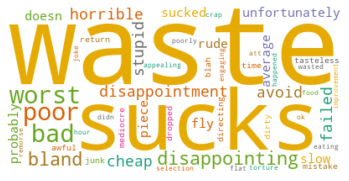

In [21]:
from wordcloud import WordCloud
wc = WordCloud(stopwords=stop_set, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)
#plt.rcParams['figure.figsize'] = [16, 6]
wc.generate(" ".join(list(vocab[neg_inds])))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")    
plt.show()

In [22]:
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB().fit(train_data, train_labels)
nb_preds_test = nb_clf.predict(test_data)
nb_errs_test = np.sum((nb_preds_test > 0.0) != (test_labels > 0.0))
print("Test error: ", float(nb_errs_test)/len(test_labels))

Test error:  0.174


In [23]:
print(nb_clf.predict(vectorizer.transform(["It's a sad movie but very good"])))

print(nb_clf.predict(vectorizer.transform(["Waste of my time"])))

print(nb_clf.predict(vectorizer.transform(["It is not what like"])))

print(nb_clf.predict(vectorizer.transform(["It is not what I m looking for"])))


[1]
[-1]
[-1]
[1]


In [25]:
from sklearn.linear_model import SGDClassifier
svm_clf = SGDClassifier(loss="hinge", penalty='l2')
svm_clf.fit(train_data, train_labels)
svm_preds_test = svm_clf.predict(test_data)
svm_errs_test = np.sum((svm_preds_test > 0.0) != (test_labels > 0.0))
print("Test error: ", float(svm_errs_test)/len(test_labels))

Test error:  0.194


In [26]:
print(svm_clf.predict(vectorizer.transform(["This is not what I like"])))

print(svm_clf.predict(vectorizer.transform(["It is not what I am looking for"])))

print(svm_clf.predict(vectorizer.transform(["I would not recommend this movie"])))


[-1]
[-1]
[1]


In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
max_review_length = 200
tokenizer = Tokenizer(num_words=10000,  #max no. of unique words to keep
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', 
                      lower=True #convert to lower case
                     )
tokenizer.fit_on_texts(sents_processed)

In [28]:
X = tokenizer.texts_to_sequences(sents_processed)
X = sequence.pad_sequences(X, maxlen= max_review_length)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (3000, 200)


In [29]:
import pandas as pd
Y=pd.get_dummies(y).values
Y

array([[1, 0],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

In [30]:
np.random.seed(0)
test_inds = np.append(np.random.choice((np.where(y==-1))[0], 250, replace=False), np.random.choice((np.where(y==1))[0], 250, replace=False))
train_inds = list(set(range(len(labels))) - set(test_inds))
train_data = X[train_inds,]
train_labels = Y[train_inds]
test_data = X[test_inds,]
test_labels = Y[test_inds]

In [31]:
EMBEDDING_DIM = 200
model = Sequential()
model.add(Embedding(10000, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(250, dropout=0.2,return_sequences=True))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          2000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 200)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 200, 250)          451000    
                                                                 
 lstm_1 (LSTM)               (None, 100)               140400    
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 2,591,602
Trainable params: 2,591,602
Non-trainable params: 0
______________________________________________

In [32]:
epochs = 2
batch_size = 40
model.fit(train_data, train_labels, 
          epochs=epochs, 
          batch_size=batch_size,
          validation_split=0.1)

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
57/57 [==============================] - ETA: 0s - loss: 0.6443 - accuracy: 0.6138WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000028630DD2158> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) a

In [ ]:
outcome_labels = ['Negative', 'Positive']
new = ["I would not recommend this movie"]
    
seq = tokenizer.texts_to_sequences(new)
padded = sequence.pad_sequences(seq, maxlen=max_review_length)
pred = model.predict(padded)
print("Probability distribution: ", pred)
print("Is this a Positive or Negative review? ")
print(outcome_labels[np.argmax(pred)])